# Multivariate OLS

In the previous module, we looked at OLS method for a single feature. In this module, we will extend the method to multiple features.

The model will have the following form:

$$ y = X\beta + \epsilon $$

Where:

- $y$ is the target variable.
- $X$ is the feature matrix. Now, $X$ is a 2D array where each column is a feature and each row is an observation.
- $\beta$ is the coefficient vector. Now, $\beta$ is a 2D array where each column is a coefficient for the corresponding feature.
- $\epsilon$ is the error term.

In this case, the general solution for $\beta$ is:

$$ \beta = (X^T X)^{-1} X^T y $$

Where:

- $X^T$ is the transpose of $X$.
- $(X^T X)^{-1}$ is the inverse of $X^T X$.

This means that we need to calculate the inverse of $X^T X$. This is a $k x k$ matrix, where $k$ is the number of features. This can be computationally expensive for large $k$.






In [2]:
import pandas as pd

btc = pd.read_csv('data/BTC_USDT_5m.csv', sep=";")[["close"]]
eth = pd.read_csv('data/ETH_USDT_5m.csv', sep=";")[["close"]]

btc.rename(columns={"close": "BTC"}, inplace=True)
eth.rename(columns={"close": "ETH"}, inplace=True)


data = pd.concat([btc, eth], axis=1)
data["BTC_lag_10"] = data["BTC"].shift(10)
data["ETH_lag_10"] = data["ETH"].shift(10)

data.dropna(inplace=True)

data = data.iloc[:500]

data.head()


,BTC,ETH,BTC_lag_10,ETH_lag_10
10,42459.55,2295.16,42397.23,2287.84
11,42475.23,2295.51,42409.96,2290.77
12,42435.53,2293.72,42488.00,2296.71
13,42436.80,2294.48,42458.85,2292.36
14,42466.33,2296.59,42473.93,2294.67


In [10]:
import statsmodels.api as sm

X = data[["BTC_lag_10", "ETH_lag_10"]]
y = data["BTC"]

X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
model.summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    BTC   R-squared:                       0.976
Model:                            OLS   Adj. R-squared:                  0.975
Method:                 Least Squares   F-statistic:                     9917.
Date:                Tue, 08 Oct 2024   Prob (F-statistic):               0.00
Time:                        16:07:00   Log-Likelihood:                -3365.1
No. Observations:                 500   AIC:                             6736.
Df Residuals:                     497   BIC:                             6749.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -769.7723    875.386     -0.879      0.380   -2489.686     950.141
BTC_lag_10     0.9242      0.031     29.512      0.000       0.863       0.986
ETH_lag_10     1.7728      0.923      1.921      0.055      -0.041       3.586
==============================================================================
Omnibus:                       36.973   Durbin-Watson:                   0.235
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               63.012
Skew:                           0.496   Prob(JB):                     2.07e-14
Kurtosis:                       4.429   Cond. No.                     4.23e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.23e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

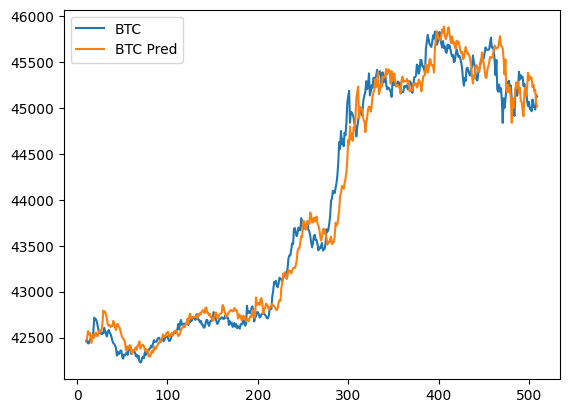

In [11]:
import matplotlib.pyplot as plt

y_pred = model.predict(X)
y_pred.name = "BTC_Pred"

plt.plot(y, label="BTC")
plt.plot(y_pred, label="BTC Pred")
plt.legend()
plt.show()


As we can see, the model is able to capture the trend of the BTC price. By using lags, we able to predict a translated version of the BTC price.

When it comes to feature significance, we can look at the p-values in the summary.



In [12]:
# Extract p-values from the model summary
p_values = model.pvalues

# Define significance level
alpha = 0.05

# Analyze p-values for each feature
for feature, p_value in p_values.items():
    if p_value < alpha:
        print(f"{feature} is significant (p-value: {p_value:.4f})")
    else:
        print(f"{feature} is not significant (p-value: {p_value:.4f})")

# Overall interpretation
print("\nInterpretation:")
if all(p_value < alpha for p_value in p_values[1:]):  # Exclude constant
    print("All features are significant in predicting BTC price.")
elif any(p_value < alpha for p_value in p_values[1:]):
    print("Some features are significant in predicting BTC price.")
else:
    print("None of the features are significant in predicting BTC price.")


const is not significant (p-value: 0.3796)
BTC_lag_10 is significant (p-value: 0.0000)
ETH_lag_10 is not significant (p-value: 0.0554)

Interpretation:
Some features are significant in predicting BTC price.


## Training and Testing

Validating the error on the training data is not enough. We need to validate the error on the testing data.



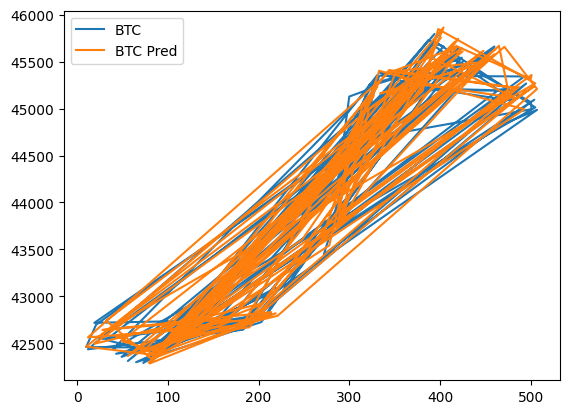

In [13]:
from sklearn.model_selection import train_test_split

X = data[["BTC_lag_10", "ETH_lag_10"]]
y = data["BTC"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

model = sm.OLS(y_train, X_train).fit()

y_pred = model.predict(X_test)

plt.plot(y_test, label="BTC")
plt.plot(y_pred, label="BTC Pred")
plt.legend()
plt.show()



In [14]:
# Calculate Mean Squared Error (MSE) on the test set
from sklearn.metrics import mean_squared_error
import numpy as np
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"Root Mean Squared Error on test set: {rmse:.2f}")

# Calculate Mean Absolute Error (MAE) on the test set
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(y_test, y_pred)

print(f"Mean Absolute Error on test set: {mae:.2f}")

# Calculate R-squared (R2) score on the test set
from sklearn.metrics import r2_score

r2 = r2_score(y_test, y_pred)

print(f"R-squared score on test set: {r2:.4f}")


Root Mean Squared Error on test set: 204.19
Mean Absolute Error on test set: 145.41
R-squared score on test set: 0.9776
